# Trabalho Prático 1 :  Classificação de Exoplanetas 

Nome: Isadora Alves de Salles <br>
Matrícula: _2017014553_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import KFold

from sklearn.svm import SVC
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from sklearn import feature_selection

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


plt.style.use('seaborn-colorblind')
plt.ion()

In [2]:
# Caminho para o dataset
INPUT_FILEPATH = "koi_data.csv"

# Nome da coluna do label
TARGET = "koi_disposition"

# Numero de features a serem usadas
N_FEATURES = 38

# Nome da coluna a ser removida, pois não é uma feature
NAME = "kepoi_name"

# Número de folds no K-fold cross-validation
N_FOLDS = 5

In [3]:
df = pd.read_csv(INPUT_FILEPATH)
# Remove colunas que nao serao usadas
df = df.drop([NAME], axis=1)

# Imprime algumas informacoes basicas sobre os dados
print("Numero de linhas: {}".format(df.shape[0]))
print("Numero de colunas: {}".format(df.shape[1]))
print("Dados faltando: {}".format(df.isnull().sum().sum()))

display(df.head())

# Cria uma lista com as features
features = list(df.columns)
features.remove(TARGET)

print("Target: {}".format(TARGET))
print("Features:")
print("\n".join(["  " + x for x in features]))

Numero de linhas: 5202
Numero de colunas: 42
Dados faltando: 0


,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,89.66,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,89.57,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,67.09,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,85.41,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,60.92,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Target: koi_disposition
Features:
  koi_period
  koi_impact
  koi_duration
  koi_depth
  koi_ror
  koi_srho
  koi_prad
  koi_sma
  koi_incl
  koi_teq
  koi_insol
  koi_dor
  koi_max_sngle_ev
  koi_max_mult_ev
  koi_model_snr
  koi_steff
  koi_slogg
  koi_smet
  koi_srad
  koi_smass
  koi_kepmag
  koi_gmag
  koi_rmag
  koi_imag
  koi_zmag
  koi_jmag
  koi_hmag
  koi_kmag
  koi_fwm_stat_sig
  koi_fwm_sra
  koi_fwm_sdec
  koi_fwm_srao
  koi_fwm_sdeco
  koi_fwm_prao
  koi_fwm_pdeco
  koi_dicco_mra
  koi_dicco_mdec
  koi_dicco_msky
  koi_dikco_mra
  koi_dikco_mdec
  koi_dikco_msky


# Pré-processamento

## Target

Criação de labels binários para a target, sendo 0 para os falso positivos e 1 para os confirmados.

In [4]:
# Imprime a porcentagem de false positive e confirmed
display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

# Criação de labels binários
df[TARGET] = (df[TARGET] == "CONFIRMED").astype(int)

print("Resultado:")
display(df[[TARGET]].sample(10))


,FALSE POSITIVE,CONFIRMED
koi_disposition (%),59.55,40.45


Resultado:


,koi_disposition
294,1
4968,0
3762,0
2945,0
2580,1
3754,0
539,1
771,1
3450,0
709,0


## Normalização

Transforma as features para que sua distribuição seja uma Normal(0,1).

In [5]:
df[features] = df[features] - df[features].mean()
df[features] = df[features] / df[features].std()

## Seleção de Features

Através do uso da função SelectKBest, que utiliza Analysis of Variance (ANOVA) para selecionar n features. O número de features foi testado e percebi que com a seleção de 38 features (variável N_FEATURES que está no início deste notebook) temos um resultado melhor. 

In [6]:
skb = feature_selection.SelectKBest(feature_selection.f_classif, N_FEATURES)
skb = skb.fit(df[features], df[TARGET])

## Separação para treino e validação

Cria um objeto com os parametros do KFold e assegura que as k particoes tenham a mesma proporção de dados das duas classes de y. Os valores são usados para validação apenas uma vez, ou seja, em cada k fold de validação teremos elementos distindos. 

In [7]:
X = skb.transform(df[features]) # Seleciona apenas as colunas das features que selecionamos na célula anterior
y = df[TARGET].values  


kf = KFold(n_splits = N_FOLDS, random_state = 1, shuffle = False)

for train_index, val_index in kf.split(X, y):
    print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]


TRAIN: [1041 1042 1043 ... 5199 5200 5201] VAL: [   0    1    2 ... 1038 1039 1040]
TRAIN: [   0    1    2 ... 5199 5200 5201] VAL: [1041 1042 1043 ... 2079 2080 2081]
TRAIN: [   0    1    2 ... 5199 5200 5201] VAL: [2082 2083 2084 ... 3119 3120 3121]
TRAIN: [   0    1    2 ... 5199 5200 5201] VAL: [3122 3123 3124 ... 4159 4160 4161]
TRAIN: [   0    1    2 ... 4159 4160 4161] VAL: [4162 4163 4164 ... 5199 5200 5201]


# Classificação

Nesta etapa há a definição de cada modelo, seguida do experimento do mesmo variando os hiperparâmetros necessários. Para cada experimento realizado foi explicado o objetivo do experimento, o significado do hiperparâmentro variado.

### Definição das variáveis globais e de funções a serem chamadas nos experimentos dos modelos

In [8]:
bestModelsTrainAcc = []
bestModelsValAcc = []
bestModelsRecall = []
bestModelsPrecision = []
bestModelsF1Score = []
bestModelsPred = []
models = ["Naive Bayes", "Decision tree", "SVM", "k-NN", "Random Forest", "Gradient Tree Boosting"]

A função abaixo foi utilizada para armazenas as características do melhor modelo encontrado em cada experimento. O melhor modelo é dado pela melhor acurácia, dado que não tenha ocorrido overfitting. Salvamos então a sua acurácia, a propabilidade de predição da classe 1 e as métricas de precisão, revocação e F1. 

In [9]:
def bestModel(trainAcc_model, valAcc_model, recall_model, f1_score_model, precision_model, predictions):
    bestModelsTrainAcc.append(trainAcc_model)
    bestModelsValAcc.append(valAcc_model)
    bestModelsPrecision.append(precision_model)
    bestModelsRecall.append(recall_model)
    bestModelsF1Score.append(f1_score_model)
    bestModelsPred.append(predictions)

A função abaixo é utilizada para plotar a curva de acurácia de treino e validação pela variação do hiperparâmetro:

In [10]:
def plot_curva(x, y1, y2, x_label, y_label):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y1, label= "Training")
    plt.plot(x, y2, label= "Validation")
    # distinção para plotar gráfico da decision tree no ponto em que temos altura ilimitada
    if x_label == "max_depth":
        trainAcc, valAcc ,_,_,_,_= decision_tree(None) 
        plt.plot([20], [trainAcc], 'ro',  ms=15, label = 'No depth limit training(y-axis only)')
        plt.plot([20], [valAcc], 'bo', ms=15, label = 'No depth limit 5-fold validation(y-axis only)')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    

## Naive Bayes


In [11]:
# definição do modelo
def naive_bayes():
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []

    for train, val in kf.split(X, y): # separa partições para validação e o resto para treino em KFolds
        
        classifier = GaussianNB() # cria o objeto do modelo
        classifier = classifier.fit(X[train], y[train]) # treina o modelo com os dados do fold
        
        # armazena a acurácia de treino e validação para cada fold
        train_score.append(classifier.score(X[train], y[train])) # calcula acurácia para o conjunto de treino
        val_score.append(classifier.score(X[val], y[val])) # calcula acurácia para o conjunto de validação
        
        y_pred = classifier.predict(X[val]) # armazena as predições no conjunto de validação
        y_proba = classifier.predict_proba(X[val]) 
        y_probab.extend(y_proba[:,1])
        
        # calculo das métricas Recall, Precision e F1 score de acordo com as predições no modelo
        f1_score.append(metrics.f1_score(y[val], y_pred))
        recall_score.append(metrics.recall_score(y[val], y_pred))
        precision_score.append(metrics.precision_score(y[val], y_pred))
        
    # calculo da média de cada métrica 
    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
    
    print("Acuracia de treino: {:.3}".format(trainAcc))
    print("Acuracia de validação: {:.3}".format(valAcc))
    print("Recall: {:.3}".format(recall))
    print("F1 score: {:.3}".format(f1))
    print("Precision: {:.3}".format(precision))
    
    
    return trainAcc, valAcc, recall, f1, precision, y_probab
    

O Naive Bayes assume que as features são indepentes e precisa de menos dados de treino, por isso é um ótimo baseline para o trabalho. 

Para o Naive Bayes como temos apenas um experimento para servir de baseline, sem a variação de nenhum hiperparâmetro, nas posição 0 dos nossos vetores que armazenam os melhores resultados de cada modelo teremos os resultados abaixo, que são os únicos para este modelo.

In [12]:
trainAcc, valAcc, recall, f1, precision, predictions = naive_bayes()
bestModel(trainAcc, valAcc, recall, f1, precision, predictions)

Acuracia de treino: 0.924
Acuracia de validação: 0.923
Recall: 0.863
F1 score: 0.719
Precision: 0.681


## Decision Tree

In [13]:
def decision_tree(H):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, y):
           
        classifier = DecisionTreeClassifier(max_depth= H)
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(y[val], y_pred))
        recall_score.append(metrics.recall_score(y[val], y_pred))
        precision_score.append(metrics.precision_score(y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
    
    return trainAcc, valAcc, recall, f1, precision, y_probab


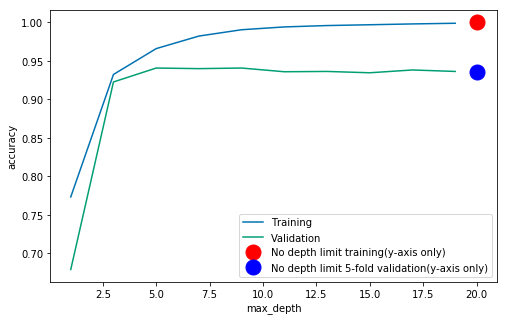

In [14]:
acc_modelTrain = []
acc_modelVal = []
max_depth = list(range(1,21,2)) #Valores usados para variar a altura da árvore 
for i in max_depth:
    trainAcc, valAcc ,_,_,_,_ = decision_tree(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(max_depth, acc_modelTrain, acc_modelVal, "max_depth", "accuracy")

Para treinar este modelo a altura/profundidade máxima da árvore de decisão foi variada de 1 a 21 (2 a 2), além de contar com o uso de "None" que implica em permitir altura máxima ilimitada. O hiperparâmentro variado ("max_depth") limita a profundidade da árvore, uma vez atingido o limite, splits não serão mais feitos. Se a altura é None, os nodes são expandidos até todas as folhas puras ou até que todas as folhas tenham menos que min_samples_split amostras. 

Como pode ser observado no gráfico, até a altura limite igual a 5 temos um ganho significativo na acurácia de validação. Após esse ponto ainda existe um aumento na acurácia de validação, porém a custo de um distanciamento grande da curva de erro empírico (acurácia no treino). Isso indica que a partir deste ponto temos overfitting, isso normalmente gera perda de geralização do modelo, ou seja, pode ser que o dado tenha sido decorado, o que não é de interesse, assim a profundidade limite para o melhor modelo é 5.

Abaixo as métricas para o melhor modelo serão salvas e há o print das acurácias de treino e validação para o modelo escolhido:

In [15]:
trainAcc, valAcc, recall, f1, precision, predictions = decision_tree(5)
bestModel(trainAcc, valAcc, recall, f1, precision, predictions)
print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))

Acuracia de treino do melhor modelo: 0.966
Acuracia de validação do melhor modelo: 0.942


## SVM

In [16]:
def svm(kernel):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, y):
            
        classifier = SVC(kernel= kernel, gamma="auto", probability= True)
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(y[val], y_pred))
        recall_score.append(metrics.recall_score(y[val], y_pred))
        precision_score.append(metrics.precision_score(y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
               
    return trainAcc, valAcc, recall, f1, precision, y_probab

In [17]:
acc_modelTrain = []
acc_modelVal = []
recall_model = []
f1_score_model = []
precision_model = []
kernels= ["linear", "sigmoid", "poly", "rbf"]    #Kernels a serem variados
for i in kernels:
    trainAcc, valAcc, recall, f1, precision, _ = svm(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
    recall_model.append(recall)
    f1_score_model.append(f1)
    precision_model.append(precision)

raw_data = {'Acuracia de Treino': acc_modelTrain, 'Acuracia de Validacao': acc_modelVal,
                'Recall': recall_model, 'F1 Score': f1_score_model, 'Precision': precision_model}
    
df = pd.DataFrame(raw_data, columns = ["Acuracia de Treino",
                    "Acuracia de Validacao", "Recall", "F1 Score", "Precision"], index=kernels) 
display(df)

,Acuracia de Treino,Acuracia de Validacao,Recall,F1 Score,Precision
linear,0.955306,0.940406,0.946716,0.746809,0.734573
sigmoid,0.828526,0.803553,0.675031,0.591123,0.616556
poly,0.870483,0.776618,0.876721,0.615506,0.615181
rbf,0.944445,0.926181,0.842322,0.721868,0.700651


Para o support vector machine (SVM) foram avaliados os 4 tipos de kernels: linear, sigmoid, polinomial e rbf. A função dos kernels para a SVM é possibilitar que o modelo, que é um classificador linear, consiga resolver problemas não linearizáveis, fazendo uma mudança de representação do dado com mudança de dimensionalidade. A função de kernel linear não faz nenhuma mudança de representação no dado, e é utilizada quando o dado original é facilmente separável pela SVM.

Como pode ser visto na tabela acima, o kernel linear apresentou melhor performance em validação tendo uma distância, em relação a acurácia de treino, muito pequena o que indica que o modelo não "overfitou". Assim, o modelo escolhido como o melhor será o que contém o kernel linear. Na célula abaixo as métricas do melhor modelo são salvas.

In [18]:
trainAcc, valAcc, recall, f1, precision, predictions = svm("linear")
bestModel(trainAcc, valAcc, recall, f1, precision, predictions)

## k-NN

In [19]:
def knn(k):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, y):
            
        classifier = neighbors.KNeighborsClassifier(n_neighbors=k)
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(y[val], y_pred))
        recall_score.append(metrics.recall_score(y[val], y_pred))
        precision_score.append(metrics.precision_score(y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
        
    return trainAcc, valAcc, recall, f1, precision, y_probab

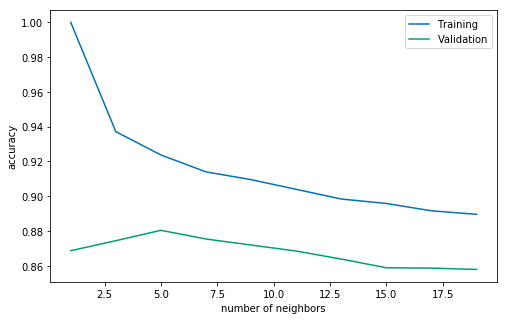

In [20]:
acc_modelTrain = []
acc_modelVal = []
n_neighbors = list(range(1,21,2)) #Valores do número de vizinhos a ser variado
for i in n_neighbors:
    trainAcc, valAcc ,_,_,_,_ = knn(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_neighbors, acc_modelTrain, acc_modelVal, "number of neighbors", "accuracy")


Para a k-NN vários modelos foram treinados com números de vizinhos diferentes, variando entre 1 e 21 (2 a 2). Tal hiperparâmetro determina o número de vizinhos que terão o seu label consultado para tomar uma decisão sobre a classe um cada um dos pontos. Por exemplo, se o número de vizinhos for igual a 10, dado um ponto a se classificar, o modelo irá avaliar a média das classes dos 10 vizinhos mais próximos deste ponto a fim de tomar uma decisão.

Como pode ser observado no gráfico acima, o melhor valor para o número de vizinhos é 5, pois é neste ponto em que observamos uma maior acurácia na validação e uma maior proximidade entre as curvas de erro esperado e empírico. A partir deste ponto o modelo começa a perder a capacidade de generalização.

Na célula abaixo as métricas do melhor modelo são salvas e há o print da acurácia de treino e validação para este modelo:


In [21]:
trainAcc, valAcc, recall, f1, precision, predictions = knn(5)
bestModel(trainAcc, valAcc, recall, f1, precision, predictions)
print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))

Acuracia de treino do melhor modelo: 0.924
Acuracia de validação do melhor modelo: 0.88


## Random Forest

In [22]:
def random_forest(N):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, y):

        classifier = ensemble.RandomForestClassifier(n_estimators=N)
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(y[val], y_pred))
        recall_score.append(metrics.recall_score(y[val], y_pred))
        precision_score.append(metrics.precision_score(y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)

    return trainAcc, valAcc, recall, f1, precision, y_probab

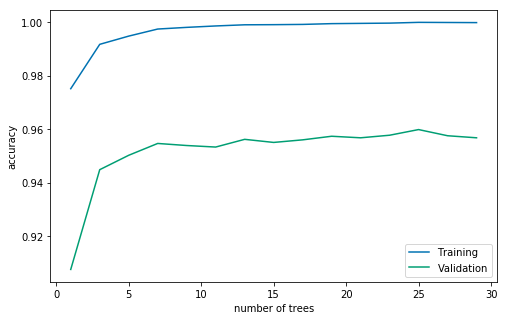

In [23]:
acc_modelTrain = []
acc_modelVal = []
n_trees = list(range(1,31,2)) #Valores do número de árvores a ser variado
for i in n_trees:
    trainAcc, valAcc ,_,_,_,_ = random_forest(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_trees, acc_modelTrain, acc_modelVal, "number of trees", "accuracy")

Para o Random Forest vários modelos foram treinados com o número de árvores variando entre 1 e 31 (2 a 2). Neste modelo é feito um ensemble de várias árvores de decisão, assim esse hiperparâmetro irá limitar o número de árvores que serão geradas durante o treino. Este tipo de classificador tenta atacar os erros que ocorrem devido a variância, utilizando a ideia de bagging o dado não será memorizado pois estamos sempre trabalhando com uma amostra do dado. Isso produz um modelo mais robusto a variãncias nos dados de teste, ou seja mais robusto a overfitting. No gráfico acima aparentemente há uma distância grande entre as curvas, mas isso é devido a escala do gráfico e ao fato de que a acurácia inicial do Random Forest já é alta.

Como pode ser observado no gráfico o melhor hiperparâmetro para o modelo, neste experimento, é o de 25 árvores, pois após este número existe um afastamento significativo entre as duas curvas, no qual a acurácia de treino continua crescendo lentamente e a acurácia de validação cai bastante, ou seja, ocorre overfitting.

Na célula abaixo as métricas do melhor modelo são salvas e há o print da acurácia de treino e validação para este modelo:

In [24]:
trainAcc, valAcc, recall, f1, precision, predictions = random_forest(25)
bestModel(trainAcc, valAcc, recall, f1, precision, predictions)
print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))

Acuracia de treino do melhor modelo: 1.0
Acuracia de validação do melhor modelo: 0.959


## Gradient Tree Boosting

In [25]:
def gradient_boosting(N):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, y):
            
        classifier = ensemble.GradientBoostingClassifier(n_estimators=N)
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(y[val], y_pred))
        recall_score.append(metrics.recall_score(y[val], y_pred))
        precision_score.append(metrics.precision_score(y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)

    return trainAcc, valAcc, recall, f1, precision, y_probab


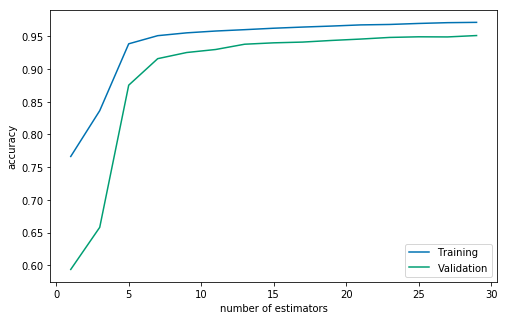

In [26]:
import warnings
warnings.filterwarnings("ignore") #ignore deprecated warnings

acc_modelTrain = []
acc_modelVal = []
n_iter = list(range(1,31,2)) #Valores do número de estimadores a ser variado
for i in n_iter:
    trainAcc, valAcc ,_,_,_,_ = gradient_boosting(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_iter, acc_modelTrain, acc_modelVal, "number of estimators", "accuracy")

Para o gradient tree boosting o hiperparâmetro variado foi o n_estimators, sendo variado de 1 a 31 (2 a 2). Esse hiperparâmetro controla o número de etapas que serão efetivadas no modelo. Este tipo de classificador é construido a partir da junção de modelos mais simples, atacando os erros devido ao viés, pois a cada iteração mudamos o viés do modelo para atacar os erros dos modelos anteriores. Assim, construimos um classificador mais robusto ao overfitting justamnete pelo uso de classificadores fracos, isso pode ser observado no gráfico acima, pois tem-se uma proximidade muito grande entre as duas curvas. A performance desse modelo tende a melhorar cada vez mais devido ao fato de que ele demora mais outros para overfitar. 

Devido a forma que é configurado, a complexidade do modelo não aumenta, assim devemos selecionar o melhor modelo dado a melhor acurácia sem nos importar com a complexidade. Assim, temos que para o gradient tree boosting o melhor modelo será o que foi testado com maior número de estimadores. Isso pode ser observado no gráfico acima, pois ambas as curvas de acurácia tendem a subir, e em nenhum momento observamos o aumento da acurácia de treino em conjunto com a diminuição da acurácia de validação (o que configuraria um overfitting), assim o melhor modelo será o com 31 estimadores, que é o maior valor testado. 


Na célula abaixo as métricas do melhor modelo são salvas e há o print da acurácia de treino e validação para este modelo:

In [27]:
trainAcc, valAcc, recall, f1, precision, predictions = gradient_boosting(31)
bestModel(trainAcc, valAcc, recall, f1, precision, predictions)
print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))

Acuracia de treino do melhor modelo: 0.972
Acuracia de validação do melhor modelo: 0.952


# Comparação entre os melhores modelos de cada classificador

Na tabela abaixo observamos que os melhores dos melhores modelos, que possuem uma acurácia de validação melhor, assim como maior precisão são o Random Forest e o Gradient Tree Boosting, que são modelos de ensemble learning possuindo tratamento especial para evitar overfitting. 

A F1 score pode ser interpretada como uma medida de confiabilidade da acurácia, uma vez que seu valor é alto sabemos que a acurácia obtida foi relevante, assim podemos observar que os maiores F1 foram também nestes dois modelos. 

#### Resumo para cada modelo:

_Naive Bayes:_ Por ser um modelo mais simples sua precisão tende a ser mais baixa que a dos outros, e devido a simplicidade do problema em questão conseguimos encontrar bons resultados com este modelo. Note que ele obteve melhores resultados do que o k-NN.

_Decision Tree:_ É um modelo mais robusto do que o Naive Bayes, mas ainda assim simples, por isso apresenta melhora na acurácia e precisão.

_SVM:_ É um dos modelos mais complexos, e apresentou um dos maiores Recall dentre os modelos avaliados, perdendo apenas para os modelos de ensemble.

_k-NN:_ Este modelo não superou o baseline (Naive Bayes). Obteve o maior recall dentre todos os modelos, porém a mais baixa precisão. 

_Random Forest:_ É mais robusto que o Decision Tree, sendo um aprimoramento do mesmo com o uso de várias decision trees. Dessa forma, quando comparados observamos que ambos têm uma acurácia relativamente próxima. Em relação ao recall, observamos que é o menor dentre todos os modelos, devido ao fato de ser mais generalista por causa do uso do bagging.

_Gradient Tree Boosting:_ É um modelo que generaliza mais que os demais modelos avaliados, pelo fato de se basear no boosting, dessa forma obteve o segundo menor recall e uma das melhores acurácias.

In [28]:
raw_data = {'Acurácia de Treino' : bestModelsTrainAcc, 'Acurácia de Validação': bestModelsValAcc,
            'Recall': bestModelsRecall, 'F1 Score': bestModelsF1Score, 'Precision': bestModelsPrecision}
    
df = pd.DataFrame(raw_data, columns = ["Acurácia de Treino","Acurácia de Validação","Recall", "F1 Score", 
                                       "Precision"], index = models)
display(df)

,Acurácia de Treino,Acurácia de Validação,Recall,F1 Score,Precision
Naive Bayes,0.924115,0.923290,0.863315,0.718747,0.680884
Decision tree,0.966023,0.941561,0.948607,0.745252,0.728740
SVM,0.955306,0.940406,0.946716,0.746809,0.734573
k-NN,0.923732,0.880416,0.952823,0.682156,0.634203
Random Forest,0.999664,0.958865,0.843645,0.762878,0.761889
Gradient Tree Boosting,0.972462,0.951751,0.850867,0.754997,0.748736


## Curva ROC

Para diferentes thresholds para a classe positiva, a curva ROC irá mostrar a taxa de verdadeiros positivos pela taxa de falsos positivos. E a área debaixo da curva encontrada expressa a capacidade do modelo de descriminar as classes.

Nas células abaixo temos a curva ROC para cada um dos melhores modelos, com a respectiva AUC:

In [29]:
bestModelsAUC = np.zeros(6)
def roc():
    i = 0
    for name, pred in zip(models, bestModelsPred):
        fpr, tpr, thresholds = metrics.roc_curve(y, pred)
        auc = np.trapz(tpr, fpr)
        bestModelsAUC[i] = auc
        plt.figure(figsize=(7, 5))
        lw = 2
        plt.plot(fpr, tpr, color='royalblue',lw=2)
        plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curva ROC ('+name+')  -  AUC: '+str(auc))
        plt.show()
        i+=1

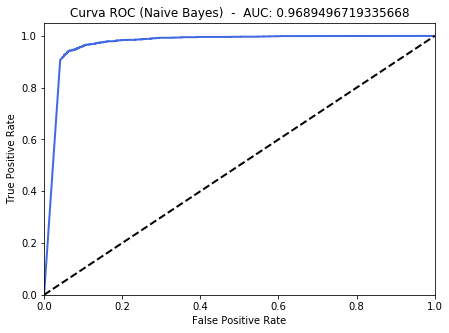

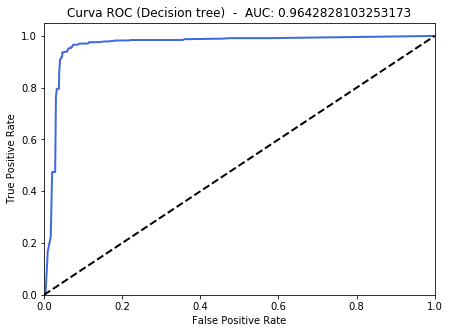

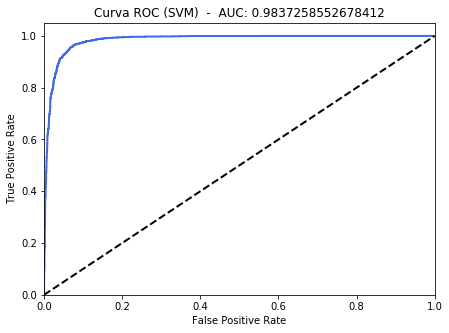

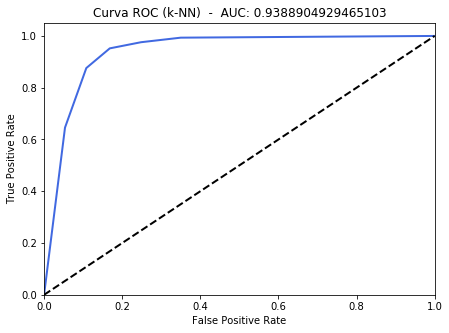

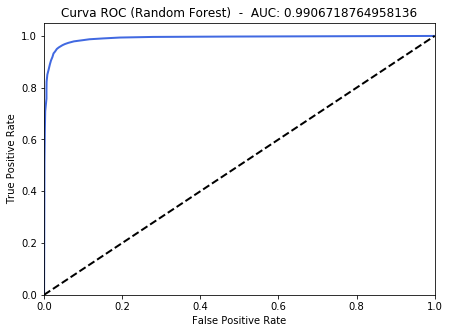

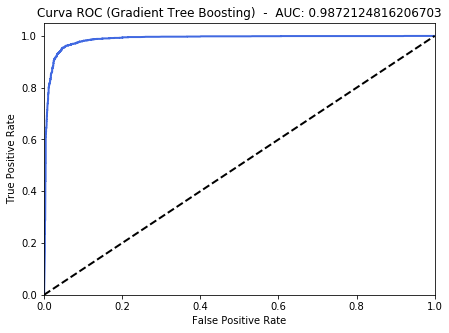

In [30]:
roc()

Nas curvas acima observamos, novamente, que os melhores modelos para este dado são realmente o Random Forest e o Gradient Tree Boosting, devido ao fato de que são baseados em emsemble learning, e possuem um tratamento especial para com os erros de viés e variância, já explicado anteriormente.

### AUC

In [31]:
raw_data = {'Area Under ROC Curve' : bestModelsAUC}
    
df = pd.DataFrame(raw_data, columns = ["Area Under ROC Curve"], index = models)
display(df)

,Area Under ROC Curve
Naive Bayes,0.968950
Decision tree,0.964283
SVM,0.983726
k-NN,0.938890
Random Forest,0.990672
Gradient Tree Boosting,0.987212
